# A notebook for descriptive statistics about the different methods.

Purpose of this notebook is to find the distribution for respective post-processing method, so that we can simulate different ratios, and have a benchmark curve, instead of a flat curve.


## 2021-06-03
Jag har alla resultat utom MSstats postprocessning.


Jag har gjort följande:


Input .mzML, .FASTA --> DIAUmpire(SE) --> MSFragger (Database search) --> Peptide & Protein Prophet (FDR estimation) --> EasyPQP (spectral library build) --> OpenSwathDecoyGenerator (Generate decoys for spectral library) --> DIA-NN quantification  


Sen konverterar jag DIA-NN quantification results till triqler input format och triqler input formatet går sedan att konvertera till msqrob format (DIA-NN quant --> triqler input .csv --> msqrob input .csv)


Sedan har jag har jag räknat fram top3 (samma som tidigare), triqler-resultat och msqrob resultat. 


.FASTA biblioteket är UniProt, only reviewed sequences, add decoys, add common contaminant, utan isoformer och utan iRT sequences. 


Jag kör DIAUmpire, MSFragger, Peptide & Protein prophet, EasyPQP via Fragpipe GUI, (körtid mer än 48h).


Jag kör OpenSwathDecoyGenerator via terminal.


Jag kör DIA-NN.exe via windows virtual-box (också GUI). (körtid ca 2h).


(Jag gör i princip allt enligt standard rekommendationer). 



Med resultatet har fixat samma plottar som tidigare... Det var mer problem än jag trodde att fixa ihop detta så allt är gjort väldigt snabbt... Det finns en del "problem" som jag inte vet om de är problem:


1) MSstat vill ha data i transition-level istället för peptid-nivå. DIA-NN:s standardkörnings resultat ger inte inte fragment--jon och fragment-intensitet, men det verkar som att det går att inkludera på något sätt. (https://github.com/vdemichev/DiaNN/issues/80)


2)   EasyPQP verkar inte lägga till specie-suffix till protein-id, så jag måste mappa om protein namn via .FASTA biblioteket. Detta gör att jag får ett 40-tal "skumma proteiner" som jag sållar bort. Dessa "skumma" proteiner tillhör andra species än ["HUMAN", "ECOLI", "YEAST"],.


3) EasyPQP verkar ta bort decoy:s så jag måste parse:a om formattet till OpenSwath:s spectral library format och generera nya med OpenSwath:s decoy generator, för att sedan konvertera tillbaka det fill EasyPQP format.

# 2021-08-19

Updated results to newest results with spectral library without shared peptides.


In [29]:
# set fcs
fcs =  [round(i*0.04,2) for i in range(20)]
# Note NEED TO CHANGE TRIQLER RESULTS DIRECTORY BELOW TO READ IN FILES 

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [31]:

import os 
import pandas as pd
import numpy as np
# git 
os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")
from triqler_output_to_df import parse_triqler
from q_value import qvalues


# db
#from get_protein_specie_map_from_fasta import fasta_to_protein_specie_map
os.chdir("/home/ptruong/git/dia_sum/database")
#protein_specie_map = fasta_to_protein_specie_map("2021-04-27-decoys-reviewed-contam-UP000005640-UP000002311-UP000000625.fas")
#protein_specie_map = protein_specie_map.set_index("protein").T.to_dict()
# MSFragger 
#os.chdir("/hdd_14T/data/PXD002952/res_20210530_DIAUmpire/MSFragger")
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")


In [32]:
df = pd.read_csv("report.tsv", sep = "\t")
triq = pd.read_csv("triqler_input_diann_searchScore_Qvalue.csv", sep = "\t")                      



In [33]:

def compute_triqler_top3_submodule(run):
    triq_run = triq[triq.run == run]   
    triq_run.searchScore = np.e**(-1 * triq_run.searchScore) #re-convert searchScore, because our triqler_input has -np.log(-Q.Value) from diann result.tsv as searchScore
    triq_run = triq_run[triq_run["searchScore"] < 0.01]
    
    def triqler_top3(triq_run):
        res = triq_run.groupby("proteins")["intensity"].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan).reset_index()
        return res
    
    def triqler_printout_unique_peptides_proteins(run):
        #triq_run = triq[triq.run == run]
        #print(len(triq_run[triq_run["searchScore"] < 0.01].peptide.unique()))
        condition = triq_run.condition.unique()
        print(f"run : {run} - condition : {condition}")
        print(f"Unique peptides detected: {len(triq_run.peptide.unique())}")
        print(f"Unique proteins detected: {len(triq_run.proteins.unique())}")
        print()
    
    triqler_printout_unique_peptides_proteins((run))
    
    res = triqler_top3(triq_run)
    #def remove_decoy_tag_protein(protein):
    #    if protein.split("_")[0] == "DECOY":
    #        return protein.split("_")[1]
    #    else: return protein.split("_")[0]
    
    #res["proteins_nonTagged"] = res.proteins.map(remove_decoy_tag_protein)
    #res["specie"] = res.proteins_nonTagged.map(protein_specie_map)
    experiment_id = triq_run.run.unique()[0]
    sample_id = triq_run.condition.unique()[0]
    #res["ProteinName"] = res["proteins"]
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    #res = res.set_index(["specie", "ProteinName"])
    #res = res.drop(["proteins", "proteins_nonTagged"], axis = 1)
    df = pd.DataFrame(res.values)
    
    specie_map = lambda x: x.split("_")[-1]
    protein_map = lambda x: x.split("_")[-2]
    res["specie"] = res.proteins.map(specie_map)
    res["ProteinName"] = res.proteins
    res = res.drop(["proteins"], axis = 1)
    res = res.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(res.values, columns = midx, index = res.index)
    return df
#df = compute_triqler_top3_submodule(run)

dfs = []
for run in triq.run.unique():
    dfs.append(compute_triqler_top3_submodule(run))
     
df = pd.concat(dfs, axis = 1)
df # Check why we have more species than in the fasta??? Is this because of how we build the spectral library?
df = df[df.index.get_level_values("specie").isin(["HUMAN", "ECOLI", "YEAST"])]

#df[df.index.get_level_values("specie").isin(["HUMAN"])]
#df[df.index.get_level_values("specie").isin(["ECOLI"])]
#df[df.index.get_level_values("specie").isin(["YEAST"])]

df = pd.concat(dfs, axis = 1)



A = df[df.iloc[:, df.columns.get_level_values("sample_id") == 1].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == 1]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == 2].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == 2]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res



import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()


/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 002-Pedro - condition : [1]
Unique peptides detected: 21036
Unique proteins detected: 3377



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 003-Pedro - condition : [2]
Unique peptides detected: 21243
Unique proteins detected: 3358



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 004-Pedro - condition : [1]
Unique peptides detected: 20783
Unique proteins detected: 3350



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 005-Pedro - condition : [2]
Unique peptides detected: 21325
Unique proteins detected: 3381



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 006-Pedro - condition : [1]
Unique peptides detected: 21040
Unique proteins detected: 3368



/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


run : 007-Pedro - condition : [2]
Unique peptides detected: 21248
Unique proteins detected: 3356



In [38]:

import time
from triqler_output_to_df import  parse_triqler

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        # Added specie mapping... need to check the problem with BOVIN, SCVLA proteins???
        #print(df_triq)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        df_triq["protein"] = df_triq["protein"] + "_" + df_triq["specie"]
        df_triq = df_triq[df_triq["specie"].isin(["HUMAN", "ECOLI", "YEAST"])]
        df_triq = df_triq[df_triq.q_value < q_val]
        #df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df


#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res
fcs =  [round(i*0.04,2) for i in range(20)]

res = get_DE_for_fcs( fcs = fcs)


In [40]:

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811")

msqrob = pd.read_csv("msqrobsum_result.csv", sep = "\t")
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (msqrob_fc["qvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res


In [45]:
def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
#os.chdir("/hdd_14T/data/PXD002952/20210805_osw_run/msstats_results")

ms = pd.read_csv("msstat_output_filtered.csv")
ms["specie"] = ms.Protein.map(specie_mapper)

In [67]:

#Rewrite this to function subplot
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()



#Rewrite this to function subplot
def plot_pq_specie_FP(specie, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        if specie == "all":
            df = pq_data(df_final, fc_treshold = fc)
            df_triq = res[i].sum(axis=1)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_triq = res[i][specie]
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)

        # False positives
        df_FP = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
        df_triq_FP = res[i]["HUMAN"]
        df_ms_FP = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
        df_msqrob_FP = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
        """
        if fc >= 1.0:
            df_FP_yeast = pq_data(df_final[df_final.index.get_level_values("specie") == "YEAST"], fc_treshold = fc)
            df_triq_FP_yeast = res[i]["YEAST"]
            df_ms_FP_yeast = msstats_pq_data(ms[ms.specie == "YEAST"], fc = fc)
            df_msqrob_FP_yeast = msqrob_pq_data(msqrob[msqrob.specie == "YEAST"], fc = fc)
            
            df_FP += df_FP_yeast
            df_triq_FP += df_triq_FP_yeast
            df_ms_FP += df_ms_FP_yeast
            df_msqrob_FP += df_msqrob_FP_yeast
        """ 
        df_triq.plot(ax = axs[row,col], style = "b") #triqler data plot
        axs[row, col].plot(df.index, df.DE, "k") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob
        
        # Plot False positives
        #res[i]["HUMAN"].plot(ax = axs[row,col], style="b--") #triqler data plot
        df_triq_FP.plot(ax = axs[row, col], style="b--")
        axs[row, col].plot(df.index, df_FP.DE, "k--") # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms_FP.DE, "g--") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob_FP.DE, "r--") # plot msqrob
        

        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob",
        #                              "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStat", "mSqRob",
                                      "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#FP ratio
def plot_ratio_FP_DE(specie, fcs):
    fig, axs = plt.subplots(4, 5,figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1))
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie])
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




#Rewrite this to function subplot
def plot_de_specie_xy(specie_x, specie_y, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        df_triq_x = res[i][specie_x]
        df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
        df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
        df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)
        
        df_triq_y = res[i][specie_y]
        df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
        df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
        df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)
        
        #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
        #axs[row, col].plot(df.index, df.DE) # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        
        axs[row, col].plot(df_triq_x.values, df_triq_y.values)
        axs[row, col].plot(df_x.values, df_y.values)
        axs[row, col].plot(df_ms_x.values, df_ms_y.values)
        axs[row, col].plot(df_msqrob_x.values, df_msqrob_y.values)
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel(f"n - Differentially expressed {specie_x}")
        axs[row, col].set_ylabel(f"n - Differentially expressed {specie_y}")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins specie ratio ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()

# PQ-plots

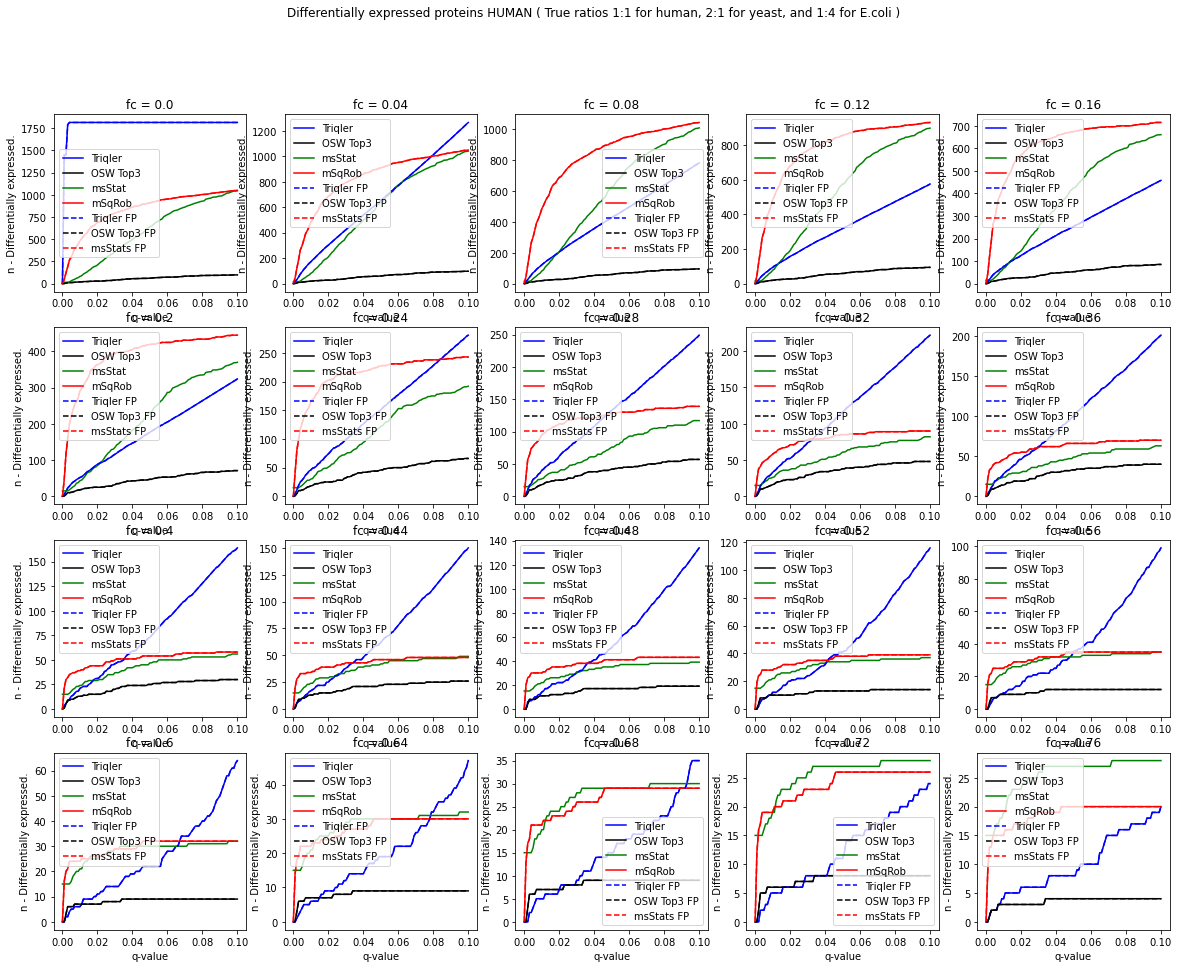

In [55]:
plot_pq_specie_FP(specie = "HUMAN", fcs = fcs)


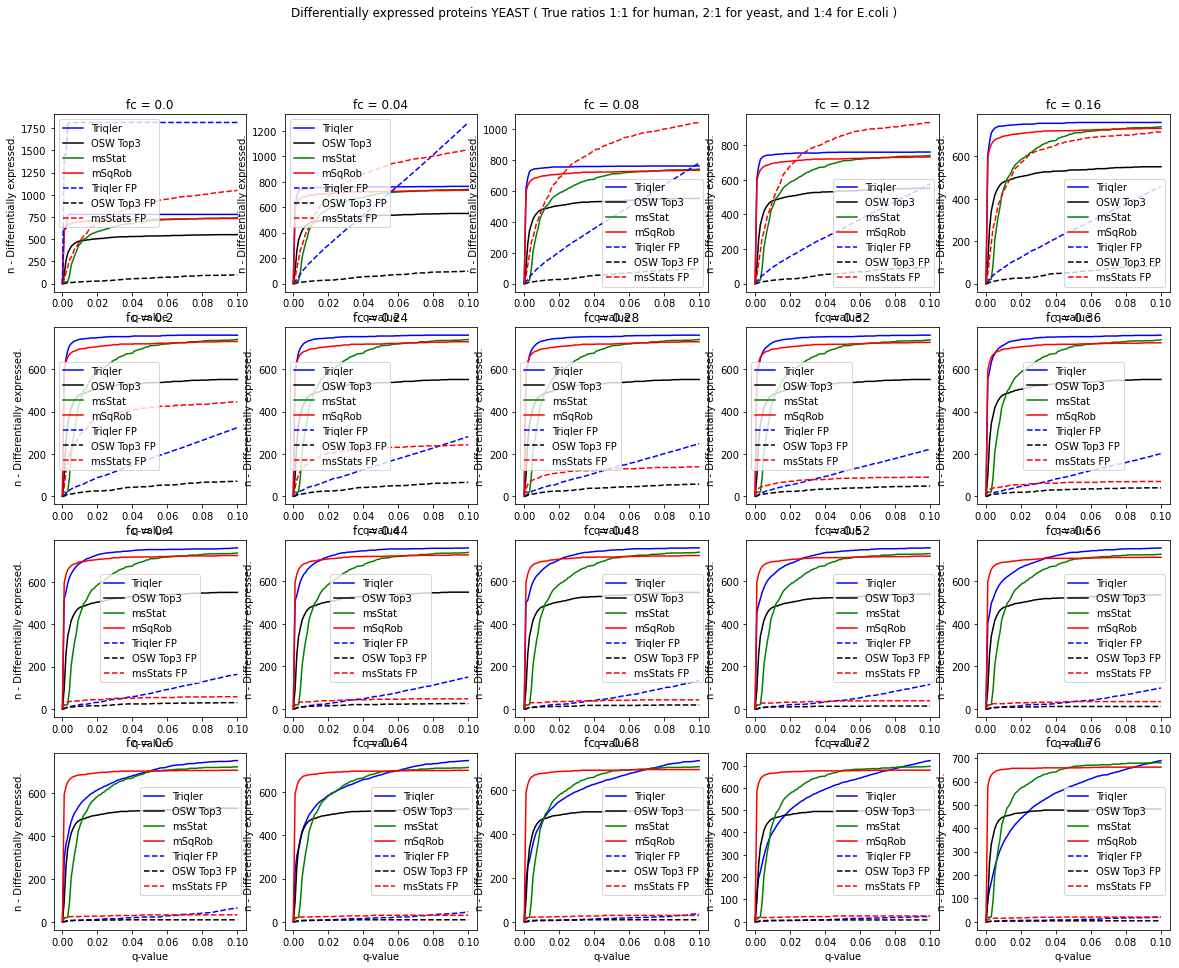

In [56]:
plot_pq_specie_FP(specie = "YEAST", fcs = fcs)


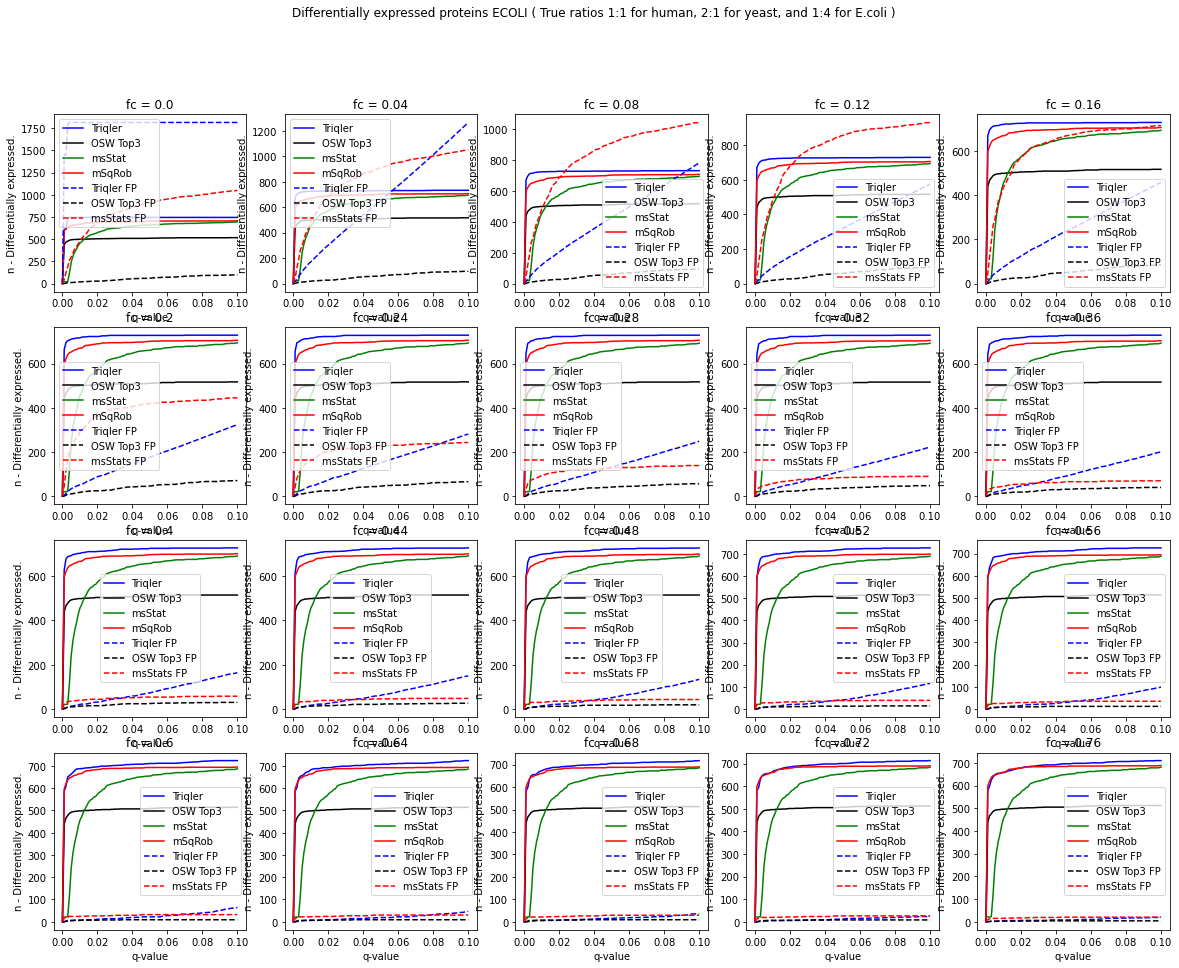

In [57]:
plot_pq_specie_FP(specie = "ECOLI", fcs = fcs)


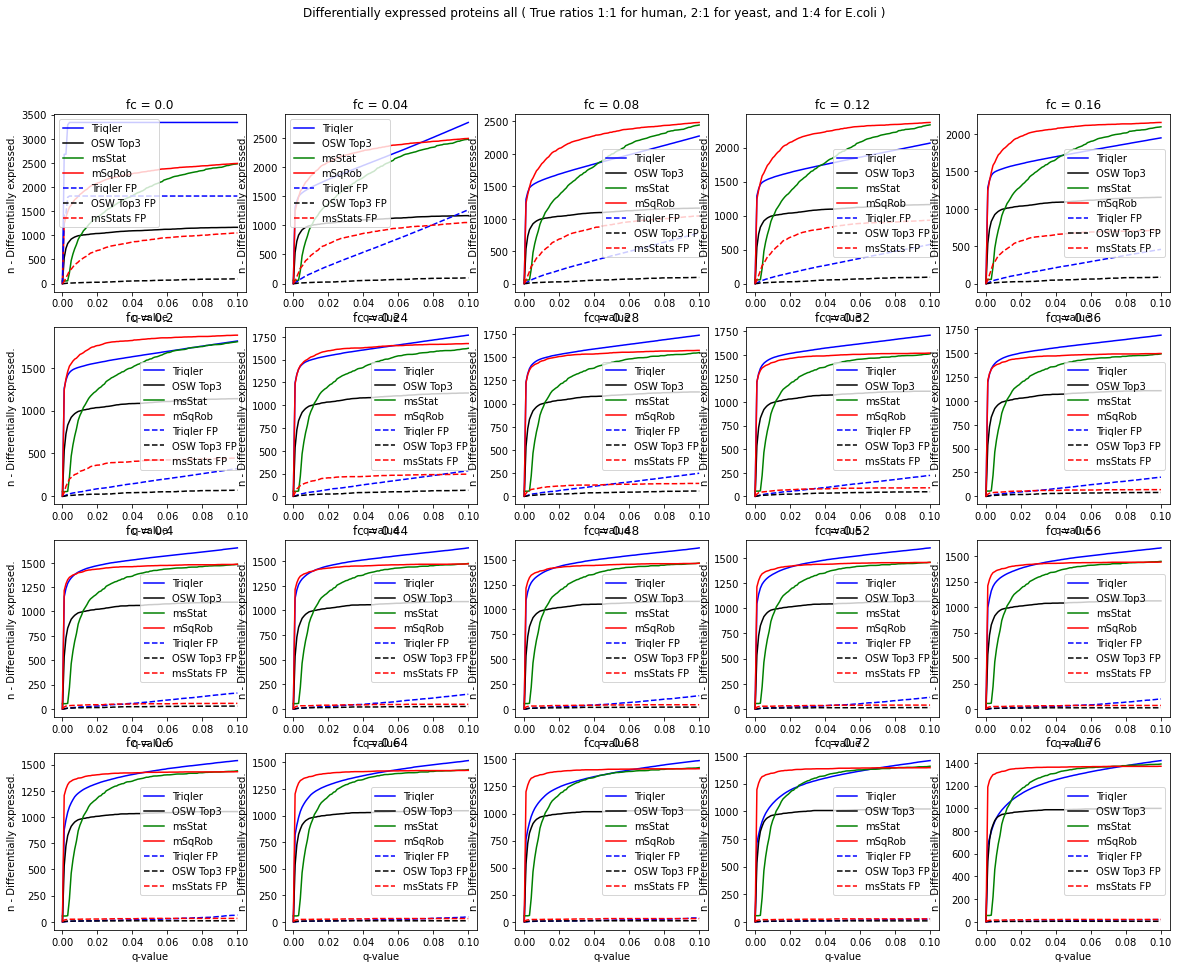

In [58]:
plot_pq_specie_FP(specie = "all", fcs = fcs)

# FP / DE ratio - Calibration plot

### FP is defined as DE-human proteins, DE is for DE for all species.

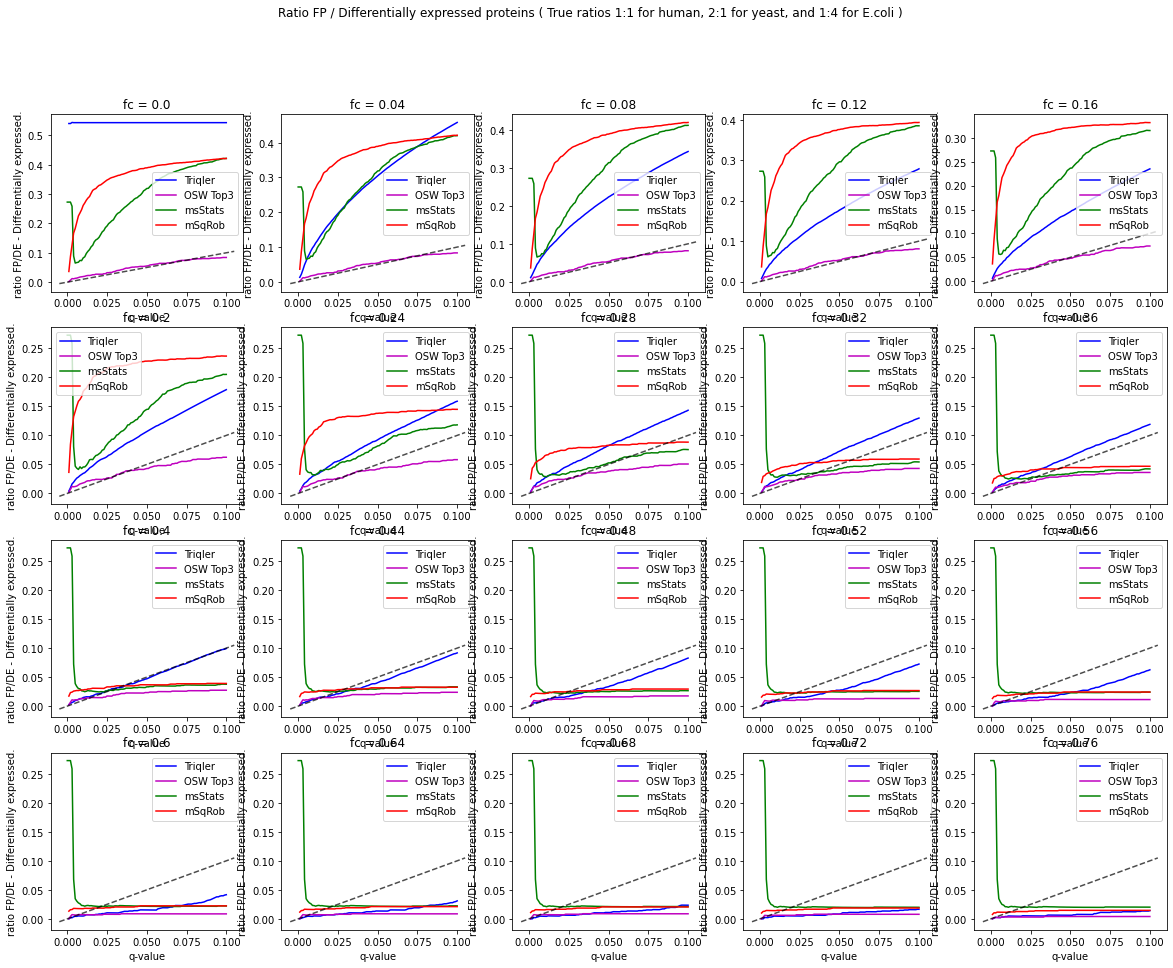

In [68]:
plot_ratio_FP_DE(specie = "all", fcs = fcs)

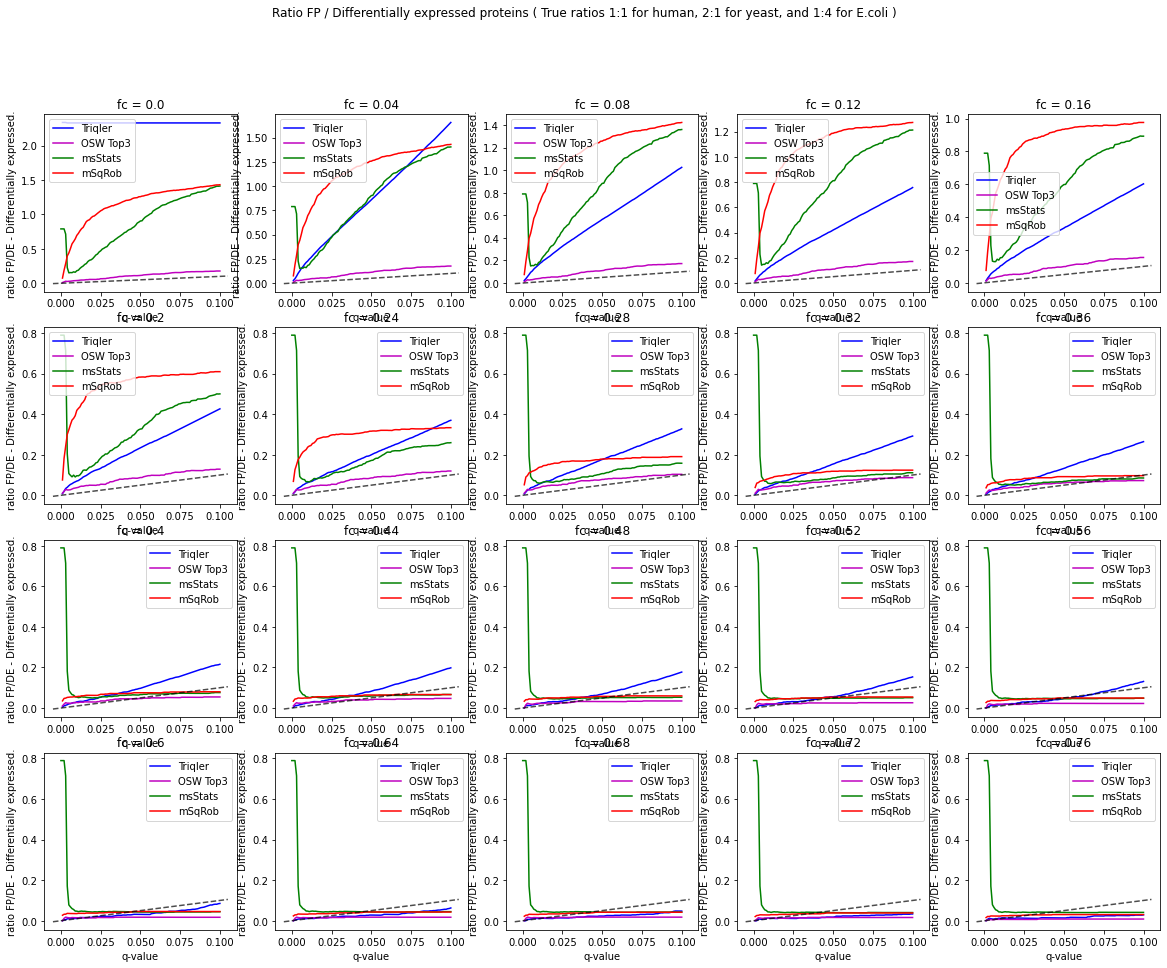

In [69]:
plot_ratio_FP_DE(specie = "YEAST", fcs = fcs)

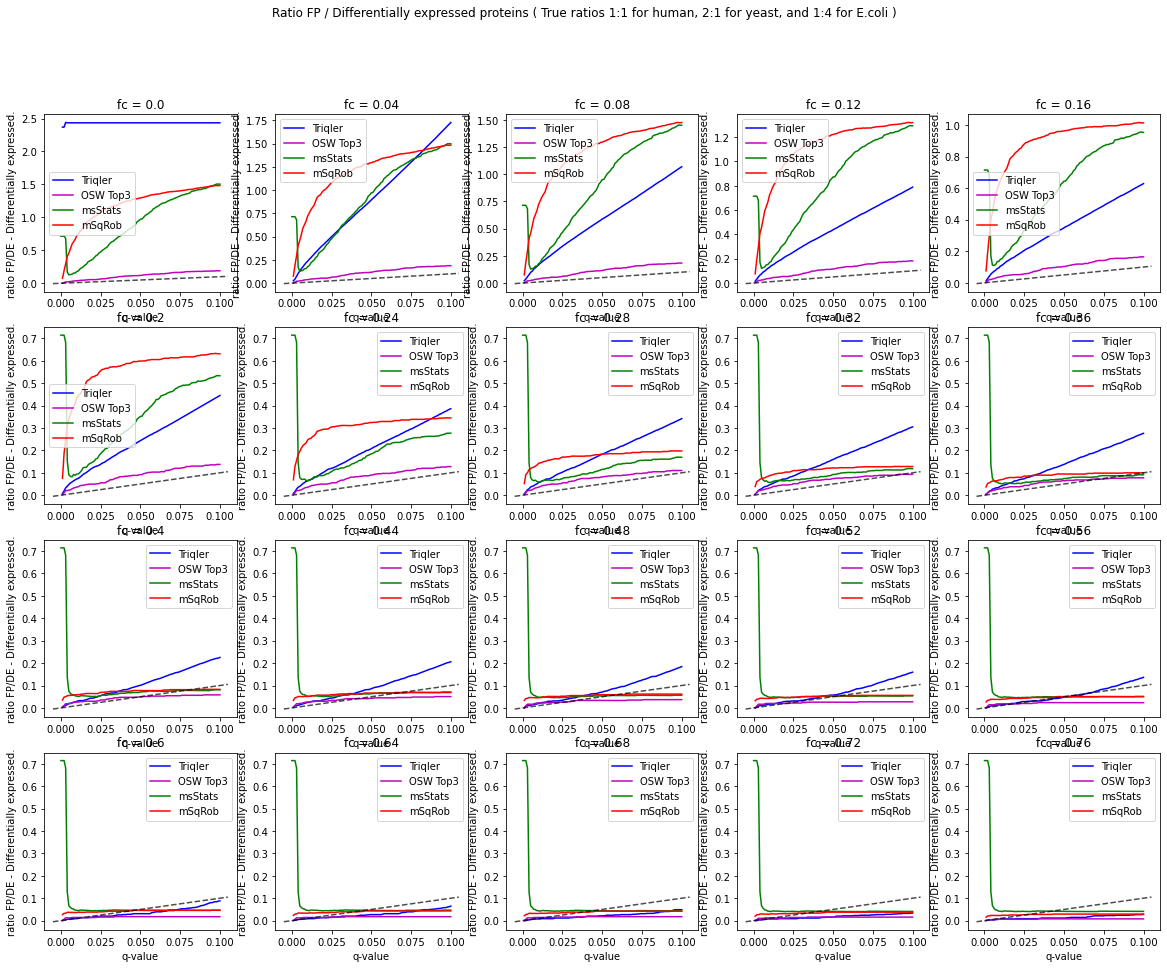

In [70]:
plot_ratio_FP_DE(specie = "ECOLI", fcs = fcs)

# DE YEAST or ECOLI as a function of DE HUMAN

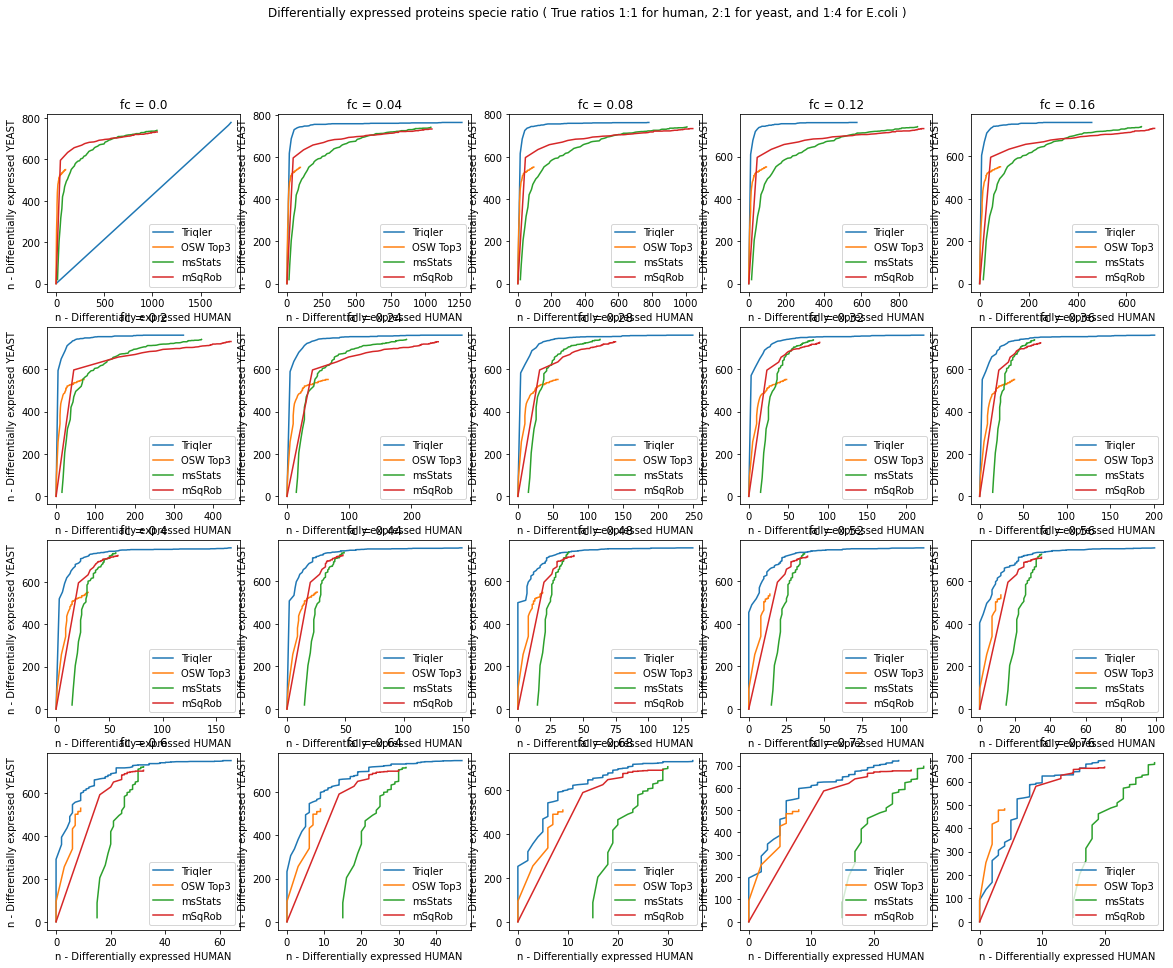

In [71]:
#plot_de_specie_xy(specie_x = "HUMAN")
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "YEAST", fcs = fcs)


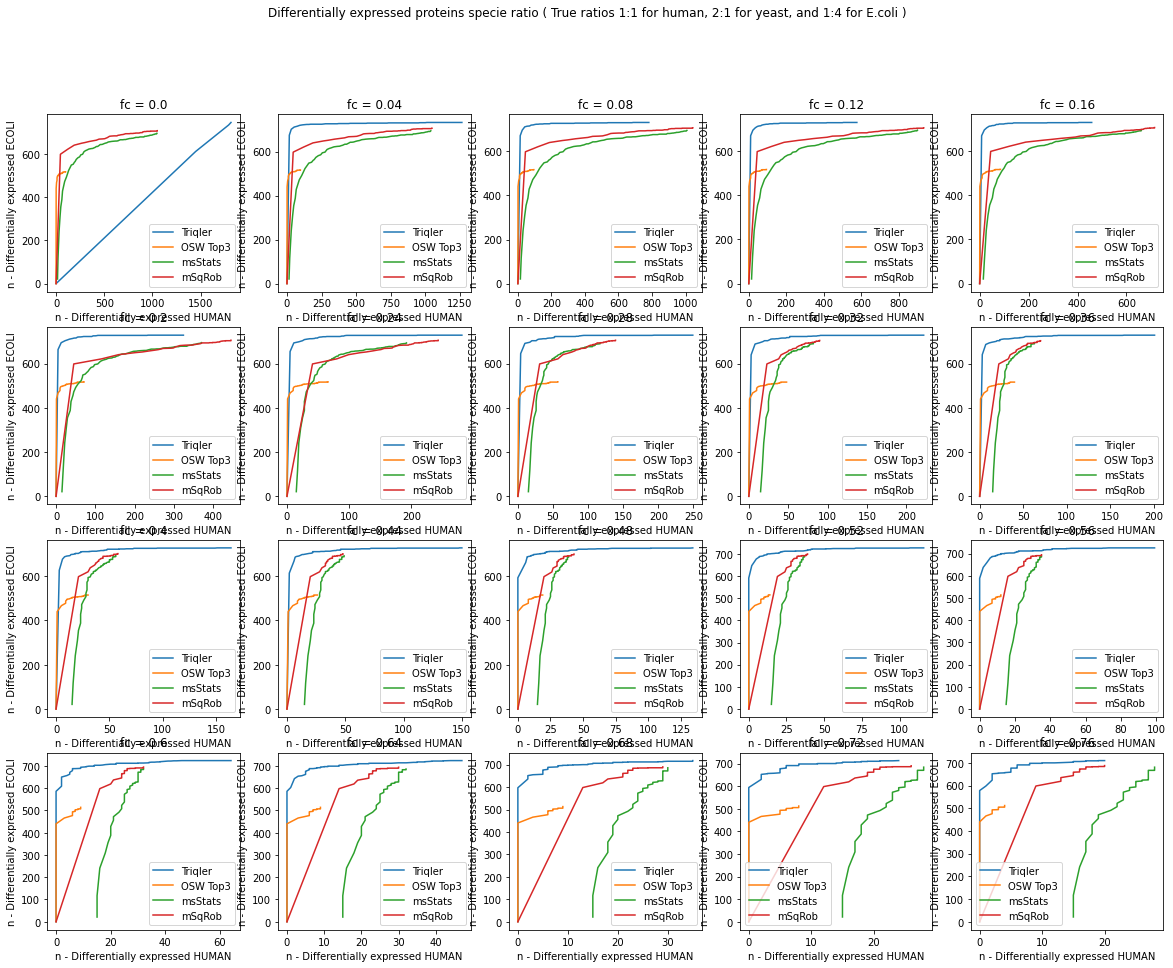

In [72]:
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "ECOLI", fcs = fcs)

# Distributions of log2FC

### Note that the log2FC are not q-value tresholded

In [73]:
import seaborn as sns

# Top3 log2FC distribution

In [74]:
df_final = df_final[df_final.index.get_level_values("specie").isin(["ECOLI", "YEAST", "HUMAN"])]
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

Text(0.5, 0.98, 'Top3 log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

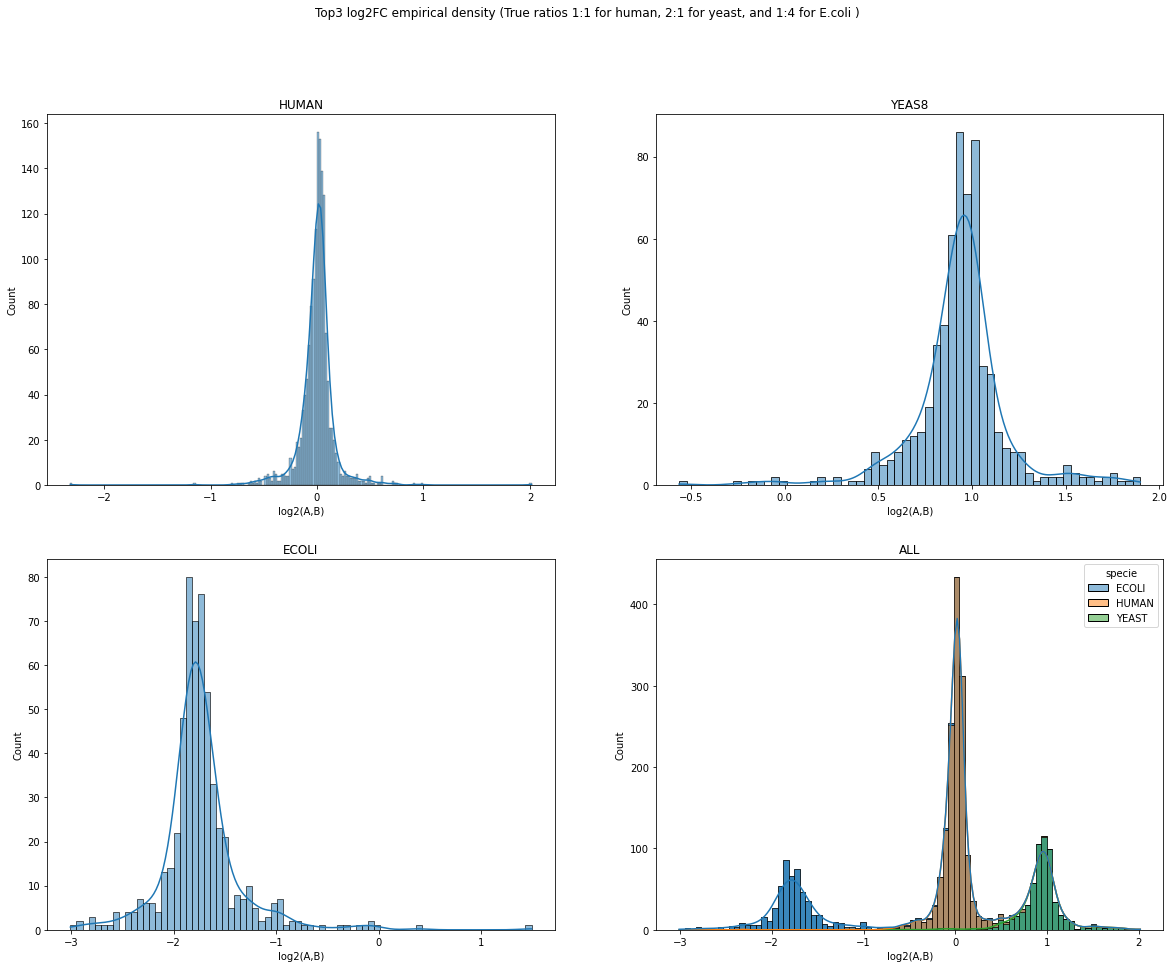

In [75]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(df_final[df_final.index.get_level_values("specie")=="HUMAN"]["log2(A,B)"], kde = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.histplot(df_final[df_final.index.get_level_values("specie")=="YEAST"]["log2(A,B)"], kde = True, ax = axs[0,1])
axs[0,1].set_title("YEAST")  
sns.histplot(df_final[df_final.index.get_level_values("specie")=="ECOLI"]["log2(A,B)"], kde = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.histplot(df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("ALL")
sns.histplot(data=df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
fig.suptitle('Top3 log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )') 

# Triqler - log2FC distribution

In [84]:

def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")
q_val = 1
file = "fc_0.60"
df_triq = parse_triqler(file)
# Added specie mapping... need to check the problem with BOVIN, SCVLA proteins???
#df_triq["specie"] = df_triq.protein.map(protein_specie_map)
df_triq["specie"] = df_triq.protein.map(specie_mapper)
#df_triq["protein"] = df_triq["protein"] + "_" + df_triq["specie"]
df_triq = df_triq[df_triq["specie"].isin(["HUMAN", "ECOLI", "YEAST"])]
df_triq["decoy"] = df_triq.protein.map(decoy_mapper)
df_triq = df_triq[df_triq.decoy == False] # remove decoy proteins.
df_triq = df_triq[df_triq.q_value < q_val]
df_triq["specie"] = df_triq.protein.map(specie_mapper)


Text(0.5, 0.98, 'Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

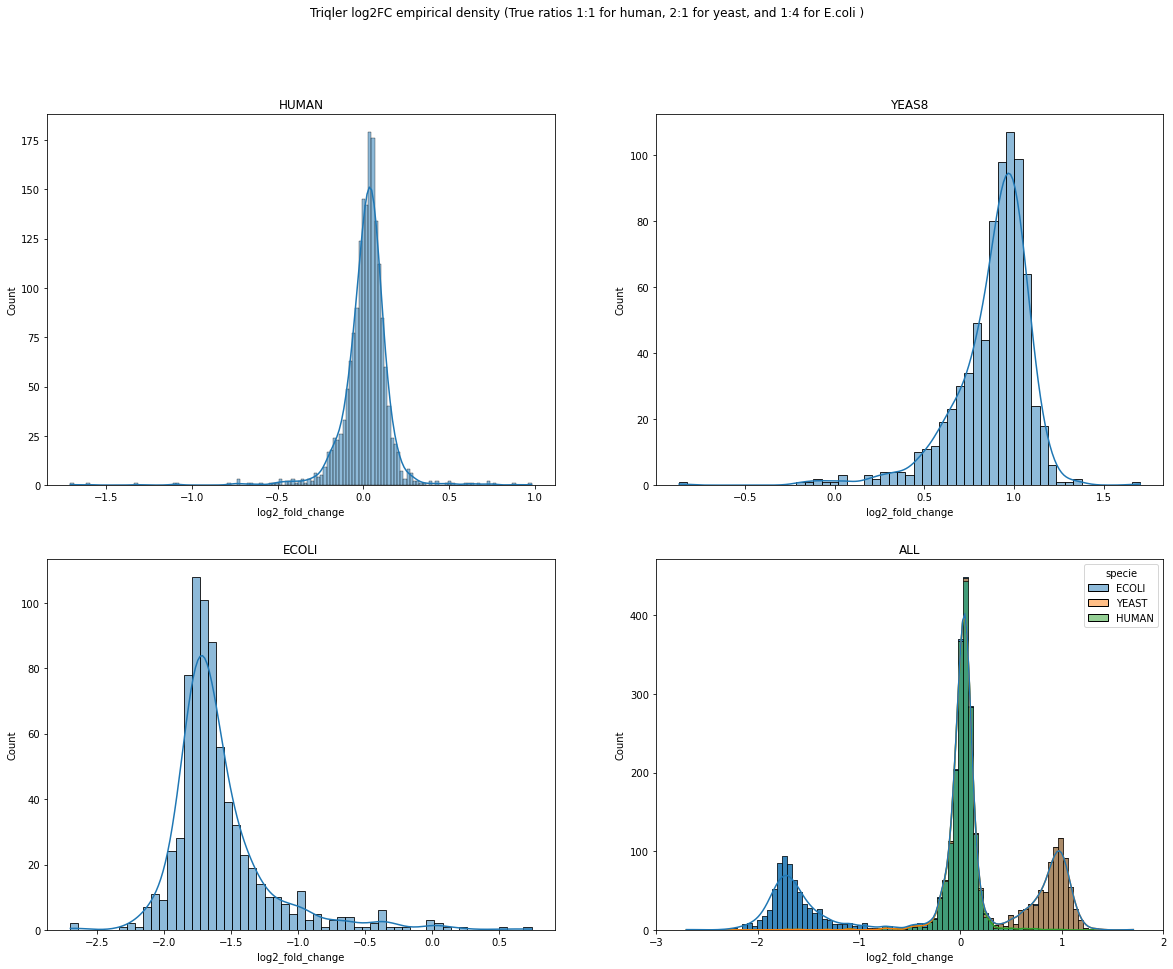

In [86]:

fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(df_triq[df_triq.specie == "HUMAN"]["log2_fold_change"], kde = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.histplot(df_triq[df_triq.specie == "YEAST"]["log2_fold_change"], kde = True, ax = axs[0,1])
axs[0,1].set_title("YEAST")  
sns.histplot(df_triq[df_triq.specie == "ECOLI"]["log2_fold_change"], kde = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.histplot(df_triq["log2_fold_change"], kde = False, ax = axs[1,1])
sns.histplot(data=df_triq, x="log2_fold_change", hue="specie", multiple="stack", kde = True)
axs[1,1].set_xlim([-3, 2])

axs[1,1].set_title("ALL")
fig.suptitle('Triqler log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')


# msqrobsum

Text(0.5, 0.98, 'msqrobsum log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

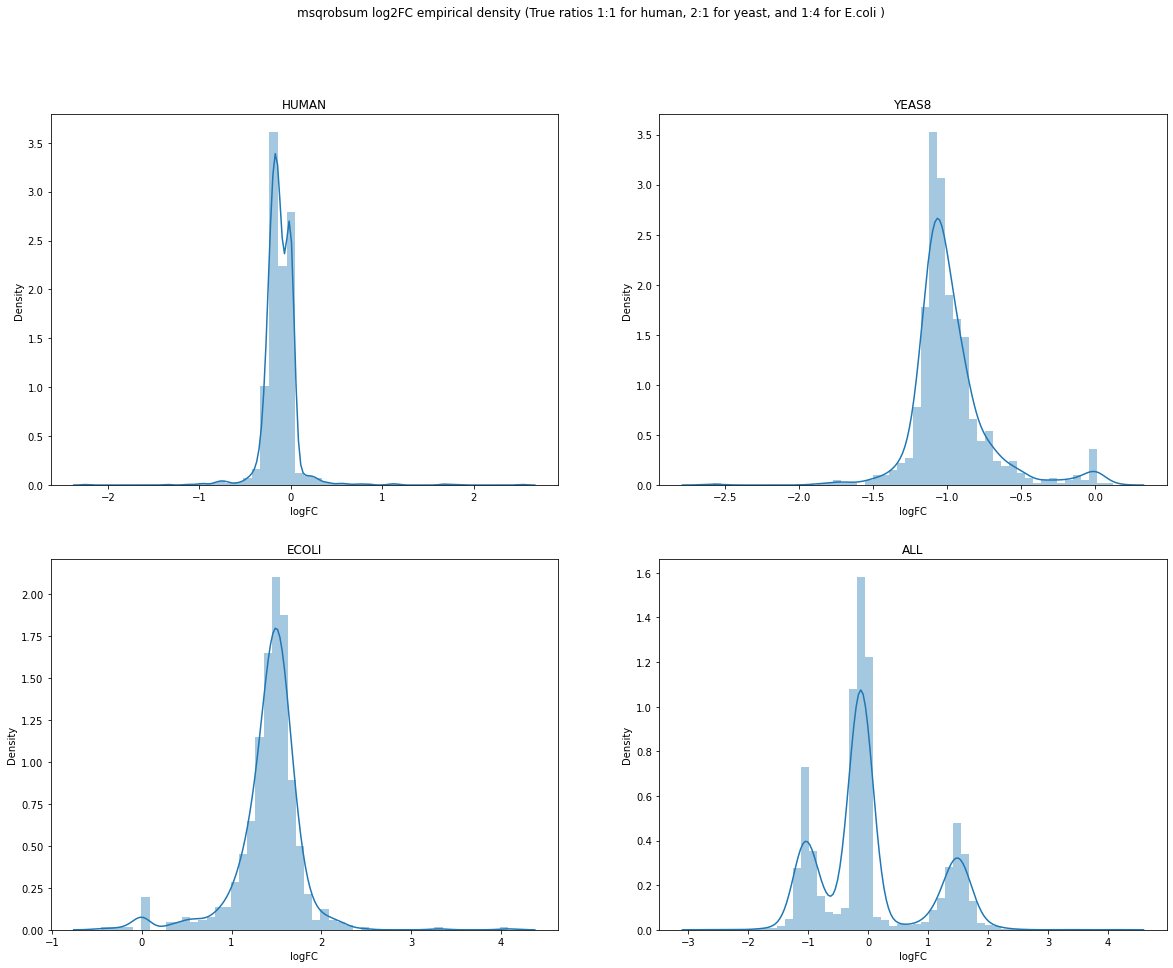

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.distplot(msqrob[msqrob.specie == "HUMAN"].logFC, hist = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.distplot(msqrob[msqrob.specie == "YEAST"].logFC, hist = True, ax = axs[0,1])
axs[0,1].set_title("YEAST")  
sns.distplot(msqrob[msqrob.specie == "ECOLI"].logFC, hist = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.distplot(msqrob.logFC, hist = True, ax = axs[1,1])
#sns.distplot(data=msqrob, x="logFC", hue="specie", multiple="stack", hist = True)
axs[1,1].set_title("ALL")
fig.suptitle('msqrobsum log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')


# 2021-06-03 Scaled calibration plots - DIA-NN

In [172]:
os.chdir("/hdd_14T/data/PXD002952/20210614_dataset/diaumpire_spectral_lib_20210706/MSFragger_20210707/diann_20210811/triqler_results")
# set fcs
# set fcs
fcs =  [round(i*0.04,2) for i in range(19)] + [0.68]

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    ecoli_scaling_factor = []
    yeast_scaling_factor = []
    human_scaling_factor = []
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        ecoli_factor = (df_triq["specie"] == "ECOLI").sum()/(df_triq["specie"] == "HUMAN").sum()
        yeast_factor = (df_triq["specie"] == "YEAST").sum()/(df_triq["specie"] == "HUMAN").sum()
        human_factor = (df_triq["specie"] == "HUMAN").sum()/(df_triq["specie"] == "HUMAN").sum()
        df_triq = df_triq[df_triq.q_value < q_val]
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        ecoli_scaling_factor.append(ecoli_factor) #Should be same for all values because we want the full length of protein list
        yeast_scaling_factor.append(yeast_factor) #Should be same for all values because we want the full length of protein list
        human_scaling_factor.append(human_factor)
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec,
                               human_scaling_factor, yeast_scaling_factor, ecoli_scaling_factor]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI", "HUMAN_factor", "YEAS8_factor", "ECOLI_factor"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            #print(df)
            try:
                val = list(df[df.index == fc].values[0])
            except:
                print(df)
                break
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI", "HUMAN_factor", "YEAST_factor", "ECOLI_factor"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)


In [173]:
def get_top3_factor(specie):
    return len(df_final[df_final.index.get_level_values("specie") == specie])/len(df_final[df_final.index.get_level_values("specie") == "HUMAN"])

#triqler_factor() # contained in res from get_DE_for_fcs - triqler read-in funciton

def get_msstat_factor(specie):
    return len(ms[ms["specie"] == specie]) / len(ms[ms["specie"] == "HUMAN"])  

def get_msqrob_factor(specie):
    return len(msqrob[msqrob["specie"] == specie]) / len(msqrob[msqrob["specie"] == "HUMAN"])

#FP ratio
def plot_ratio_FP_DE_scale(fcs,specie):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        top3_factor = get_top3_factor(specie)
        msstat_factor = get_msstat_factor(specie)
        msqrob_factor = get_msqrob_factor(specie)
        
        
        if specie == "all":
            top3_factor =  get_top3_factor("HUMAN") + get_top3_factor("ECOLI") + get_top3_factor("YEAST")
            msstat_factor = get_msstat_factor("HUMAN") + get_msstat_factor("ECOLI") + get_msstat_factor("YEAST")
            msqrob_factor = get_msqrob_factor("HUMAN") + get_msqrob_factor("ECOLI") + get_msqrob_factor("YEAST")
            
            
            df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))) * (top3_factor)
            df_triq = ((res[i]["HUMAN"] / 
                       res[i].sum(axis=1))) * (res[i]["HUMAN_factor"]+res[i]["ECOLI_factor"] +res[i]["YEAST_factor"] )
            df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))) * msstat_factor
            df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))) * msqrob_factor        
        else:
            df = ((pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))) * top3_factor
            df_triq = ((res[i]["HUMAN"] / 
                       res[i][specie])) * res[i][specie + "_factor"]
            df_ms = ((msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))) * msstat_factor
            df_msqrob = ((msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))) * msqrob_factor   

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


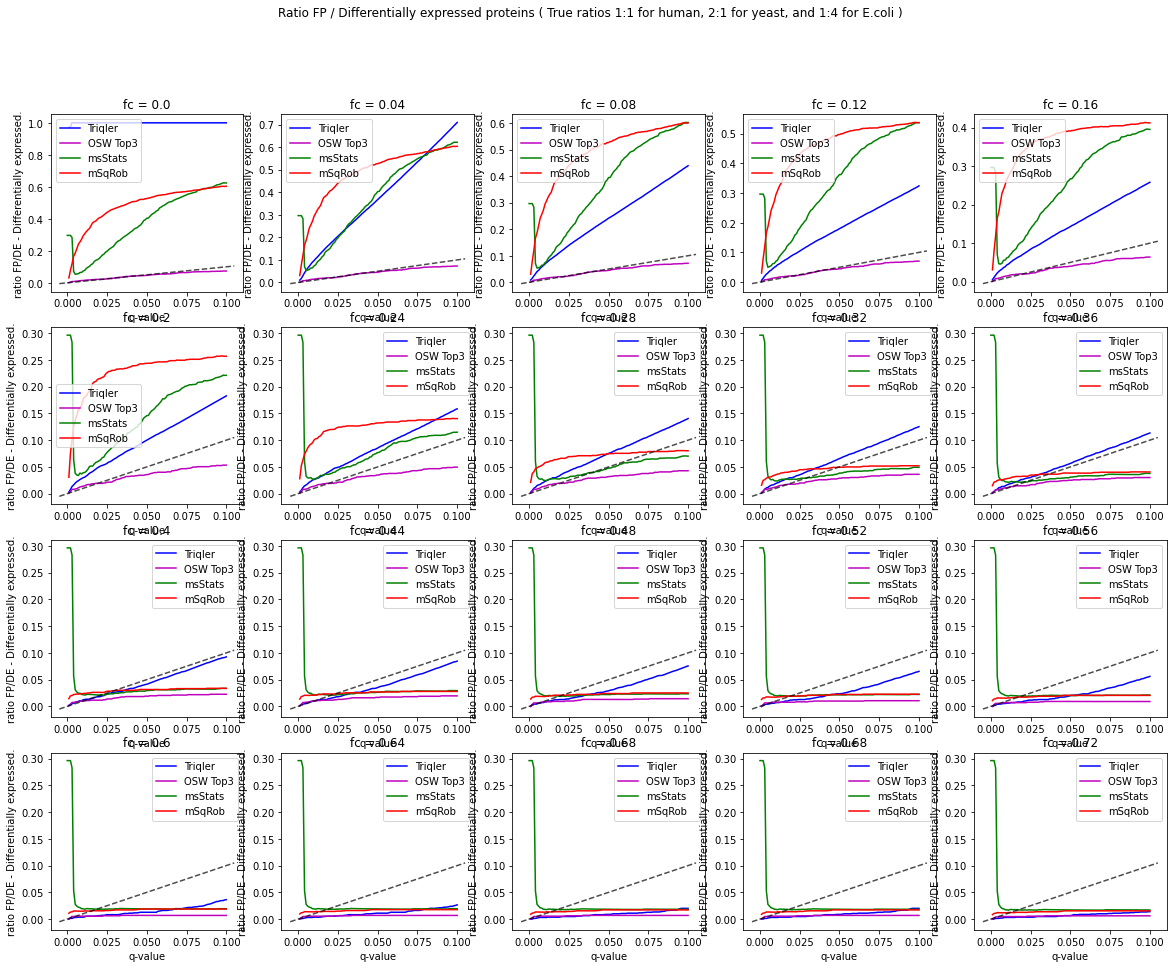

In [174]:
plot_ratio_FP_DE_scale(fcs, "ECOLI")

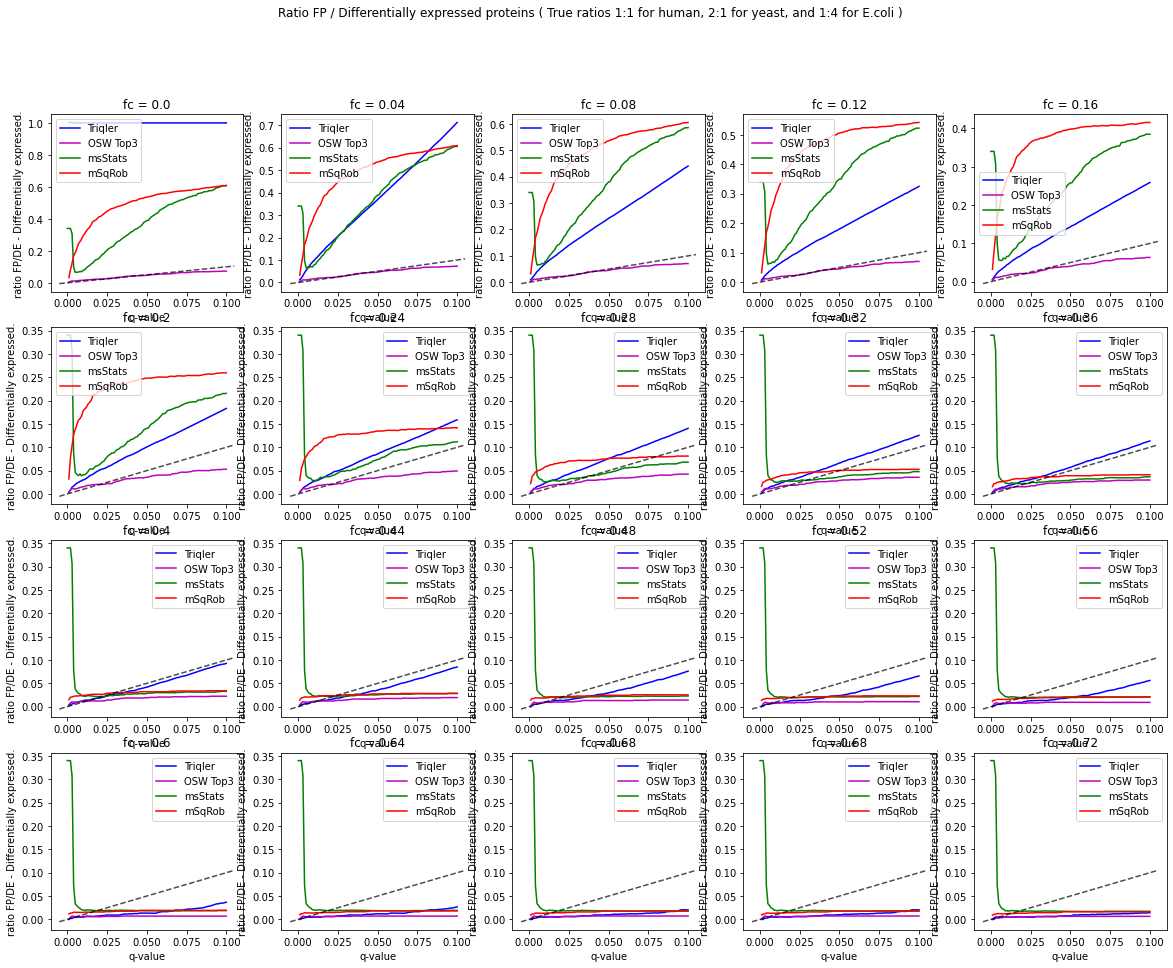

In [175]:
plot_ratio_FP_DE_scale(fcs, "YEAST")

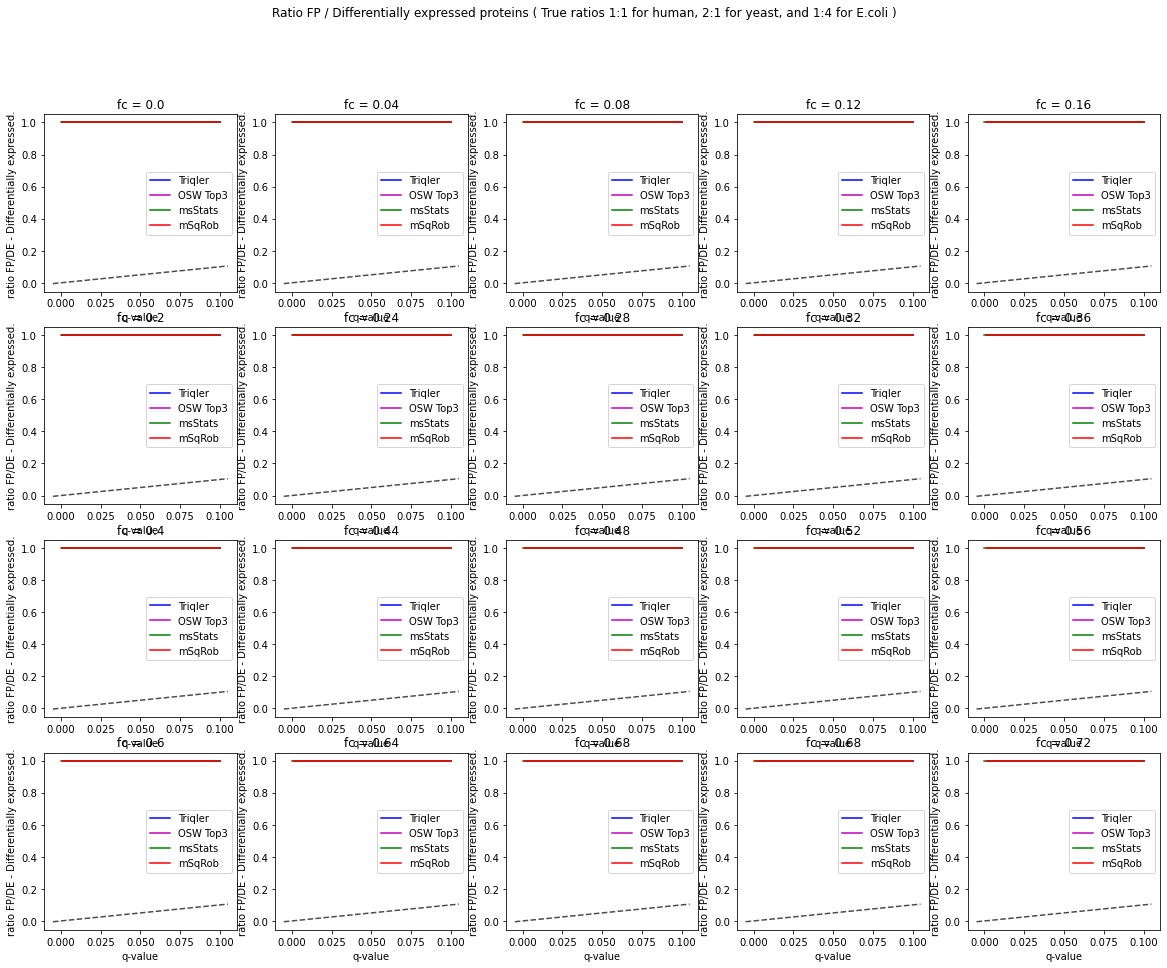

In [176]:
plot_ratio_FP_DE_scale(fcs, "HUMAN")

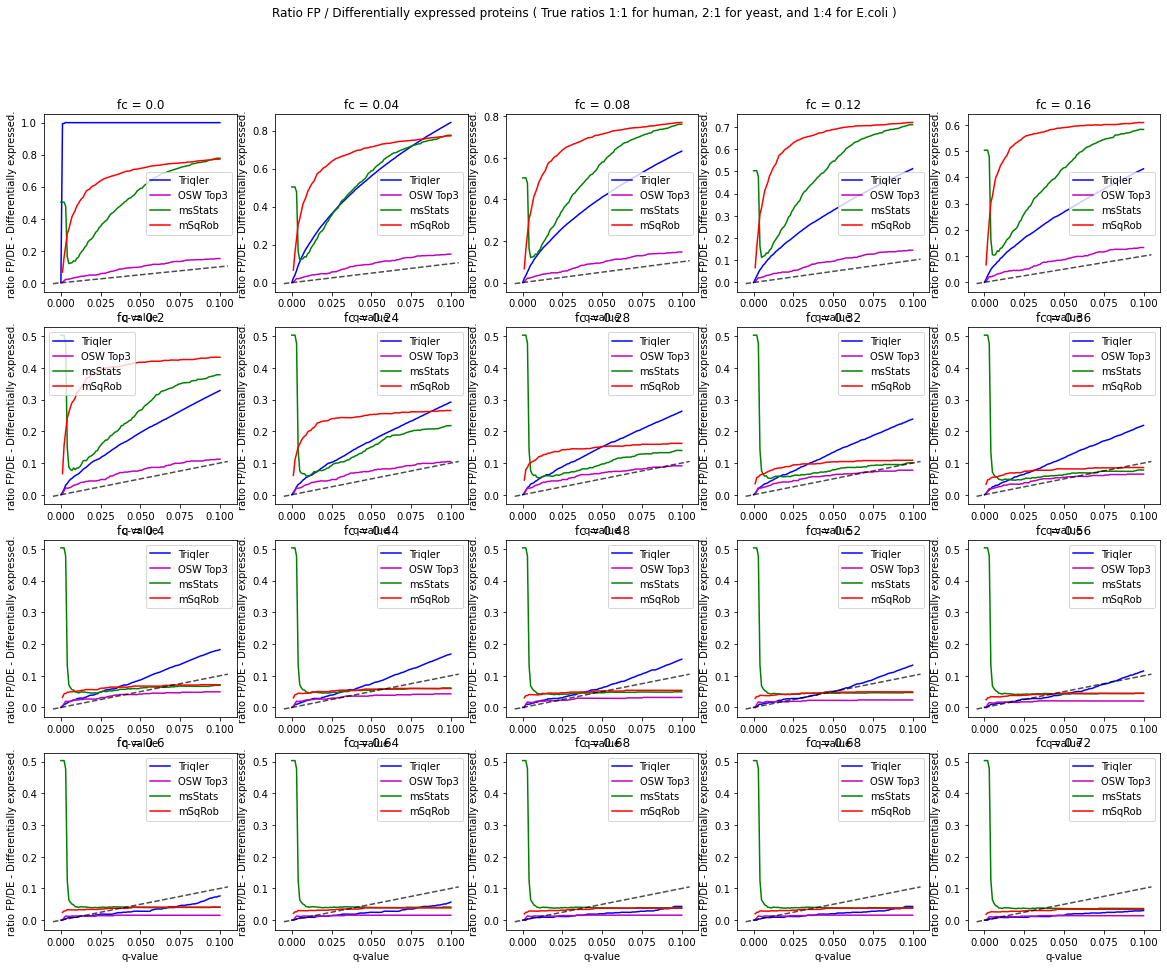

In [177]:
plot_ratio_FP_DE_scale(fcs, "all")

# NOTE: FC 0.43 is minimum advisable FC treshold for triqler.

If we use the scaled FP/DE plot we see that the optimum is right around, where minimum advisable FC is.